In [1]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
from scipy.spatial import Delaunay


In [2]:
def in_hull(p, hull):
    if hasattr(hull, 'vertices') and not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)
    elif not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0

def get_hull_centroid(hull, log =False):
    # Extract ordered convex hull vertices
    polygon = hull.points[hull.vertices]
    if log:
        polygon = np.log10(polygon)

    # Close the polygon if needed
    if not np.allclose(polygon[0], polygon[-1]):
        polygon = np.vstack([polygon, polygon[0]])

    x, y = polygon[:, 0], polygon[:, 1]
    cross = x[:-1] * y[1:] - x[1:] * y[:-1]
    area = 0.5 * np.sum(cross)

    if np.isclose(area, 0):
        return np.mean(polygon, axis=0)  # fallback for degenerate polygon

    cx = np.sum((x[:-1] + x[1:]) * cross) / (6 * area)
    cy = np.sum((y[:-1] + y[1:]) * cross) / (6 * area)

    return np.array([cx, cy])

In [3]:
def in_hull_list(p, hulls):
   return np.any([in_hull(p, hull) for hull in hulls], axis=0)

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
main_df = main_df.copy()
main_df = main_df[main_df["failure_type"] == "pass"]
np.random.seed(0)

In [5]:
main_df["hull_centroid"] = main_df["hull"].apply(get_hull_centroid)

# Remote

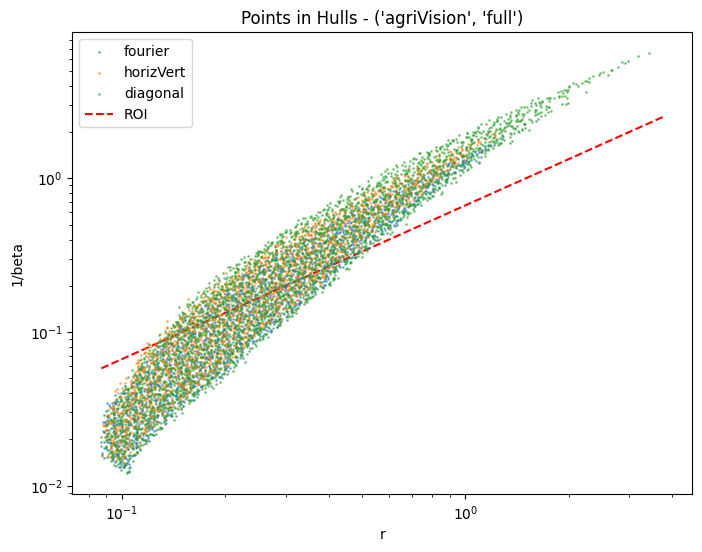

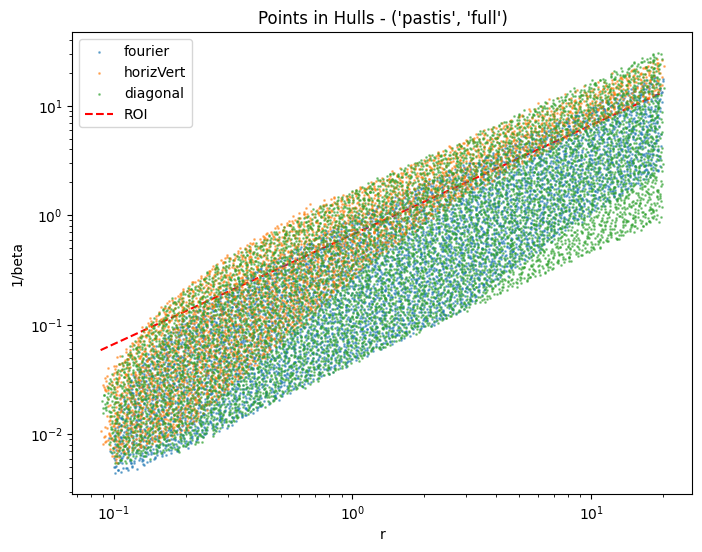

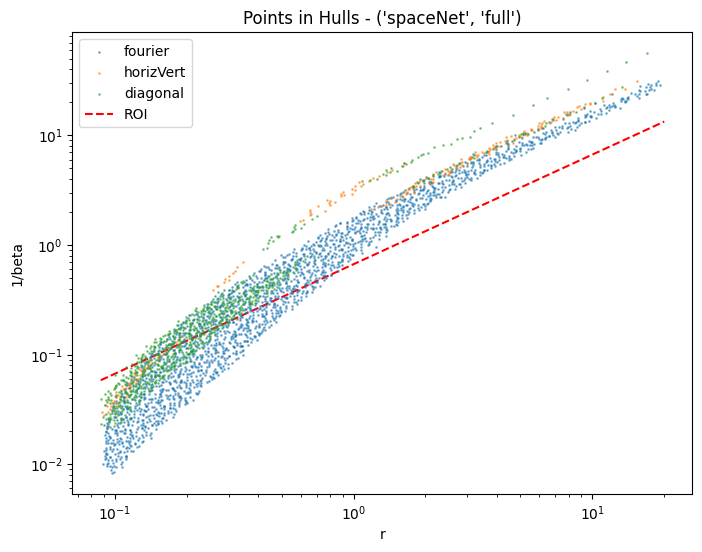

In [6]:
num_points = 150
JITTER_FACTOR = 50
size = 1
for DATASET in [("agriVision", "full"), ("pastis", "full"), ("spaceNet", "full")]:
    df = main_df [(main_df["dataset"] == DATASET[0]) &  (main_df["subset"] == DATASET[1]) &(main_df["transform"] != "learned")]
    df = df.dropna(subset=["hull"])
    df["best_1/beta"] = 1/df["best_beta"]
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    plt.figure(figsize=(8, 6))

    color_map = plt.get_cmap('tab10')
    orientation_colors = {orientation: color_map(i % 10) for i, orientation in enumerate(orientation_list)}

    #x_vals = np.linspace(xmin, xmax, num_points)
    #y_vals = np.linspace(ymin, ymax, num_points)
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    eta_vals = 0 * np.ones_like(x_vals)
    roi_beta = (eta_vals + 1.5) / x_vals
    roi = 1 / roi_beta

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for i, hull in enumerate(hull_list):
        hull_mask  = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        # Scale jitter inversely with the number of points (avoid division by zero)
        points = points + np.random.normal(scale=points/JITTER_FACTOR, size=points.shape)

        plt.scatter(points[:, 0], points[:, 1], s=size, label = orientation_list[i], alpha=0.5, color =orientation_colors[orientation_list[i]])
    for orientation in orientation_list:
        temp_df = df[df["orientation"] == orientation]
        hull_centroid = np.array(temp_df["hull_centroid"].values)
        hull_centroid = np.array(hull_centroid.tolist())
       
        #plt.scatter(hull_centroid[:, 0], hull_centroid[:, 1], s=size*100, label=f"{orientation} best", alpha=1, marker='x', color=orientation_colors[orientation])
    plt.plot(x_vals, roi, color='red', linestyle='--', label='ROI', zorder = 0)
    plt.xlabel("r")
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("1/beta")
    plt.title(f"Points in Hulls - {DATASET}")
    plt.legend()

    

# Natural

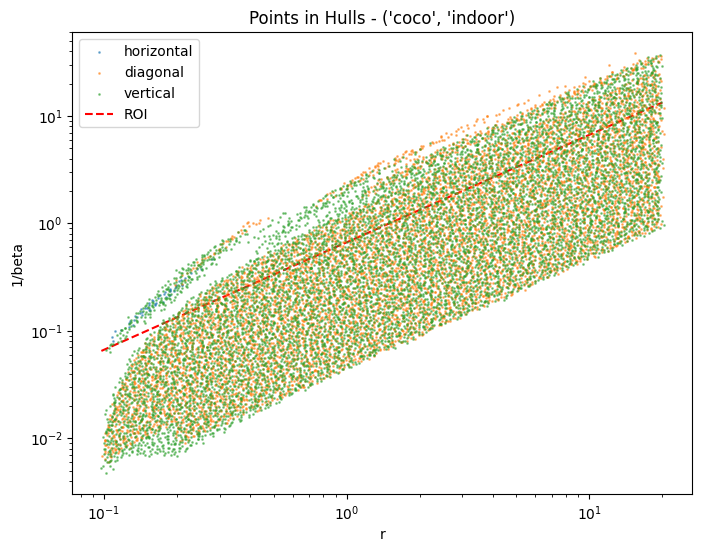

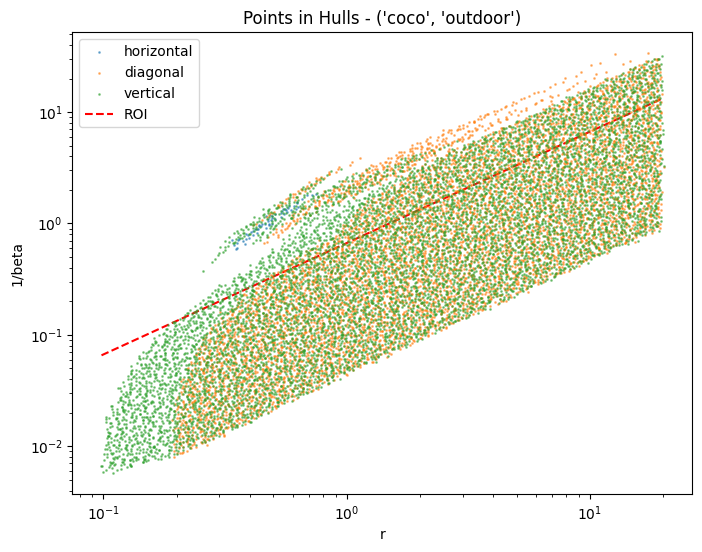

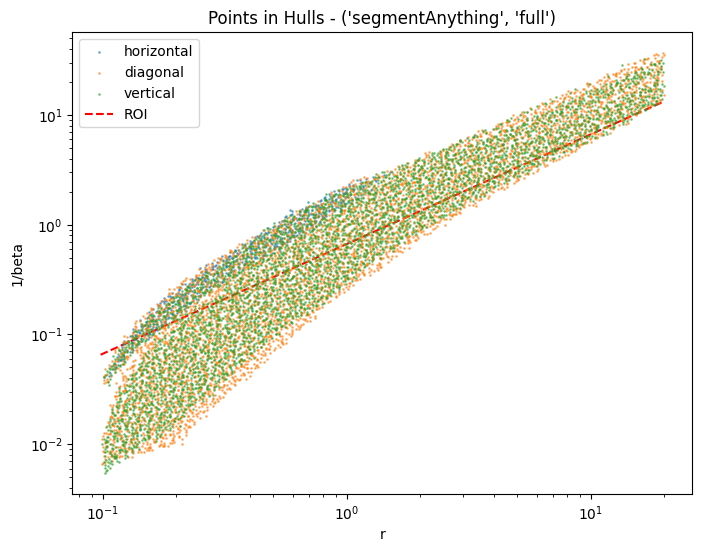

In [7]:
num_points = 150
JITTER_FACTOR = 50
size = 1
for DATASET in [("coco", "indoor"), ("coco", "outdoor"), ("segmentAnything", "full")]:
    df = main_df [(main_df["dataset"] == DATASET[0]) &  (main_df["subset"] == DATASET[1]) &(main_df["transform"] != "learned")]
    df = df.dropna(subset=["hull"])
    df["best_1/beta"] = 1/df["best_beta"]
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    plt.figure(figsize=(8, 6))

    color_map = plt.get_cmap('tab10')
    orientation_colors = {orientation: color_map(i % 10) for i, orientation in enumerate(orientation_list)}

    #x_vals = np.linspace(xmin, xmax, num_points)
    #y_vals = np.linspace(ymin, ymax, num_points)
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    eta_vals = 0 * np.ones_like(x_vals)
    roi_beta = (eta_vals + 1.5) / x_vals
    roi = 1 / roi_beta

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for i, hull in enumerate(hull_list):
        hull_mask  = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        # Scale jitter inversely with the number of points (avoid division by zero)
        points = points + np.random.normal(scale=points/JITTER_FACTOR, size=points.shape)

        plt.scatter(points[:, 0], points[:, 1], s=size, label = orientation_list[i], alpha=0.5, color =orientation_colors[orientation_list[i]])
    for orientation in orientation_list:
        temp_df = df[df["orientation"] == orientation]
        hull_centroid = np.array(temp_df["hull_centroid"].values)
        hull_centroid = np.array(hull_centroid.tolist())

        #plt.scatter(hull_centroid[:, 0], hull_centroid[:, 1], s=size*10, label=f"{orientation} best", alpha=1, marker='x', color=orientation_colors[orientation])
    plt.plot(x_vals, roi, color='red', linestyle='--', label='ROI', zorder = 0)
    plt.xlabel("r")
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("1/beta")
    plt.title(f"Points in Hulls - {DATASET}")
    plt.legend()
    

# Medical

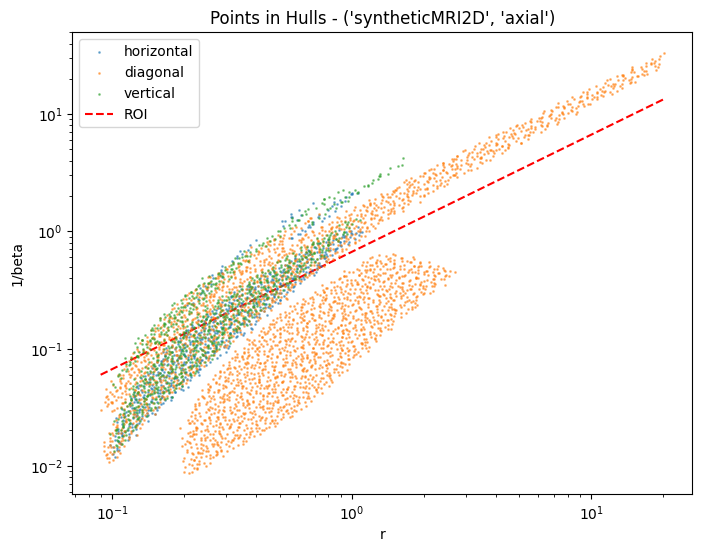

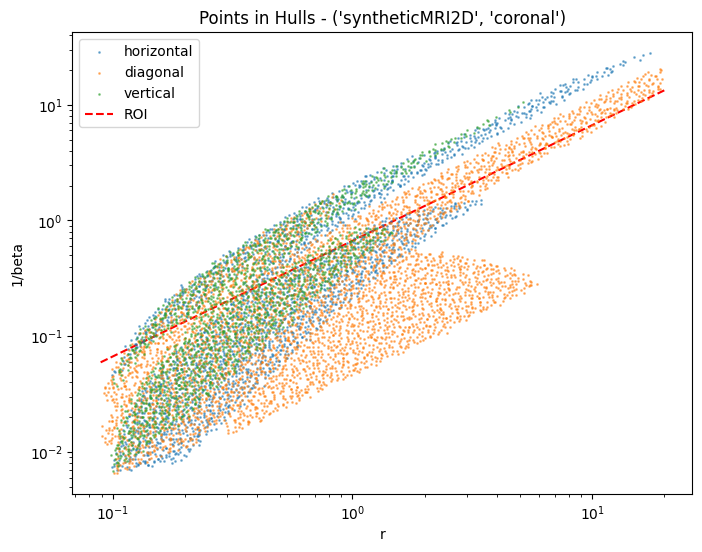

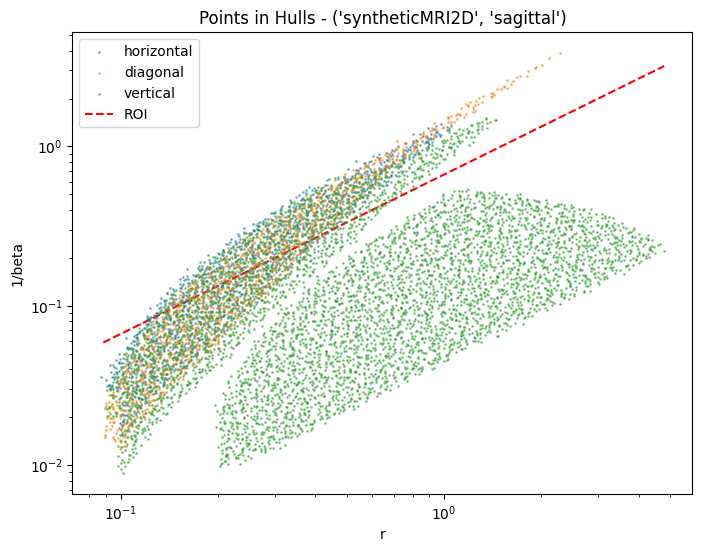

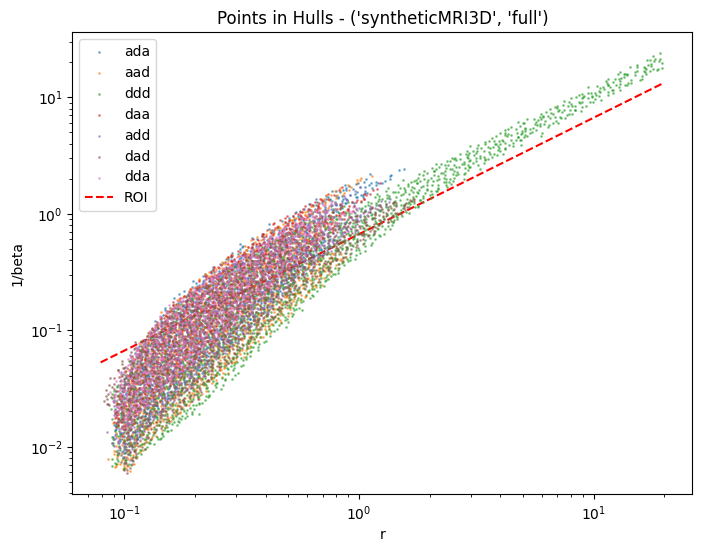

In [8]:
num_points = 125
JITTER_FACTOR = 50
size = 1
for DATASET in [("syntheticMRI2D", "axial"), ("syntheticMRI2D", "coronal"), ("syntheticMRI2D", "sagittal"), ("syntheticMRI3D", "full")]:
    df = main_df [(main_df["dataset"] == DATASET[0]) &  (main_df["subset"] == DATASET[1]) &(main_df["transform"] != "learned")]
    df = df.dropna(subset=["hull"])
    df["best_1/beta"] = 1/df["best_beta"]
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    plt.figure(figsize=(8, 6))

    color_map = plt.get_cmap('tab10')
    orientation_colors = {orientation: color_map(i % 10) for i, orientation in enumerate(orientation_list)}

    #x_vals = np.linspace(xmin, xmax, num_points)
    #y_vals = np.linspace(ymin, ymax, num_points)
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    eta_vals = 0 * np.ones_like(x_vals)
    roi_beta = (eta_vals + 1.5) / x_vals
    roi = 1 / roi_beta

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for i, hull in enumerate(hull_list):
        hull_mask  = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        # Scale jitter inversely with the number of points (avoid division by zero)
        points = points + np.random.normal(scale=points/JITTER_FACTOR, size=points.shape)

        plt.scatter(points[:, 0], points[:, 1], s=size, label = orientation_list[i], alpha=0.5, color =orientation_colors[orientation_list[i]])
    for orientation in orientation_list:
        temp_df = df[df["orientation"] == orientation]
        hull_centroid = np.array(temp_df["hull_centroid"].values)
        hull_centroid = np.array(hull_centroid.tolist())

        #plt.scatter(hull_centroid[:, 0], hull_centroid[:, 1], s=size*10, label=f"{orientation} best", alpha=1, marker='x', color=orientation_colors[orientation])
    plt.plot(x_vals, roi, color='red', linestyle='--', label='ROI', zorder = 0)
    plt.xlabel("r")
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("1/beta")
    plt.title(f"Points in Hulls - {DATASET}")
    plt.legend()

In [9]:
np.unique(main_df["dataset_type"])

array(['medical', 'natural', 'remote sensing'], dtype=object)

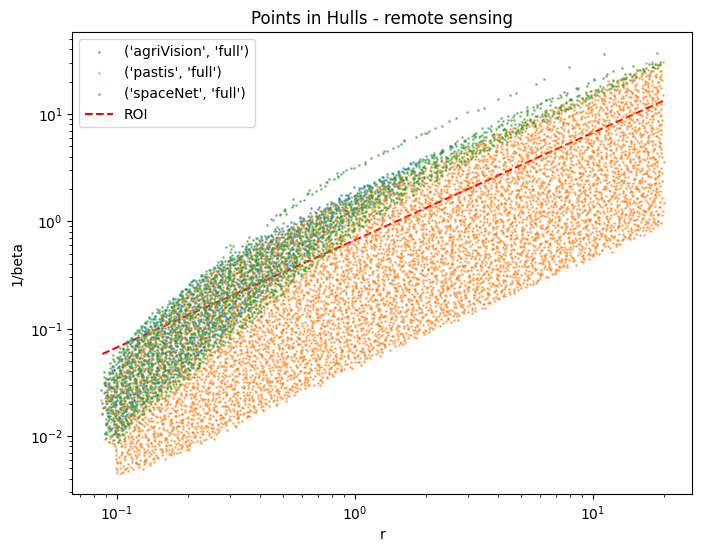

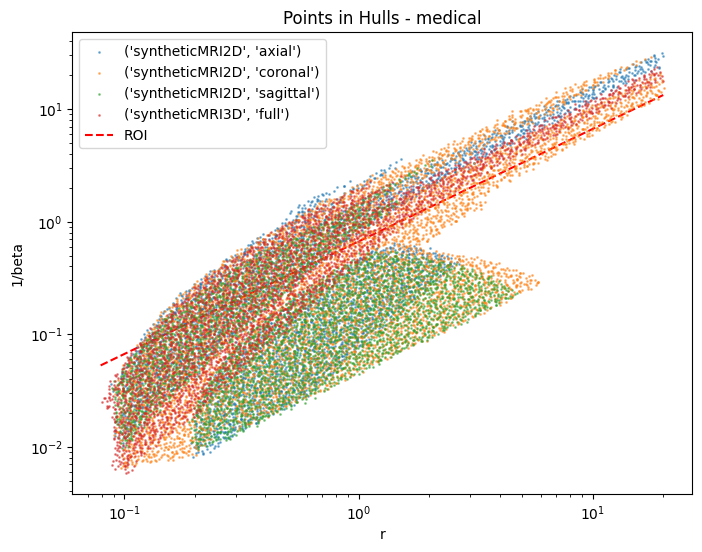

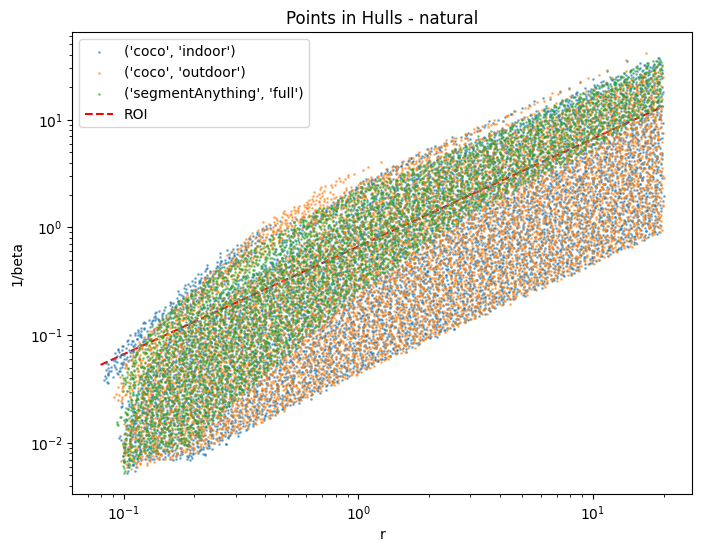

In [10]:
num_points = 150
JITTER_FACTOR = 50
size = 1
for DATASET_TYPE in ["remote sensing", "medical", "natural"]:
    df = main_df[main_df["dataset_type"] == DATASET_TYPE]
    df = df.dropna(subset=["hull"])
    dataset_list = [tuple(x) for x in np.unique(list(zip(df["dataset"], df["subset"])), axis=0)]
    hull_list = []
    all_hulls = []
    for dataset in dataset_list:
        hull_list.append(df[(df["dataset"] == dataset[0]) & (df["subset"] == dataset[1])]["hull"])
        all_hulls.extend(df[(df["dataset"] == dataset[0]) & (df["subset"] == dataset[1])]["hull"])
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()
    plt.figure(figsize=(8, 6))

    color_map = plt.get_cmap('tab10')
    dataset_colors = {dataset: color_map(i % 10) for i, dataset in enumerate(dataset_list)}
    #x_vals = np.linspace(xmin, xmax, num_points)
    #y_vals = np.linspace(ymin, ymax, num_points)
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    eta_vals = 0 * np.ones_like(x_vals)
    roi_beta = (eta_vals + 1.5) / x_vals
    roi = 1 / roi_beta

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for i, hull in enumerate(hull_list):
        hull_mask  = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        # Scale jitter inversely with the number of points (avoid division by zero)
     
        points = points + np.random.normal(scale=points/JITTER_FACTOR, size=points.shape)

        plt.scatter(points[:, 0], points[:, 1], s=size, label = dataset_list[i], alpha=0.5, color=dataset_colors[dataset_list[i]])
    for dataset in dataset_list:
        temp_df = df[df["dataset"] == dataset[0]]
        hull_centroid = np.array(temp_df["hull_centroid"].values)
        hull_centroid = np.array(hull_centroid.tolist())

        #plt.scatter(hull_centroid[:, 0], hull_centroid[:, 1], s=size*10, label=f"{dataset} best", alpha=1, marker='x', color=dataset_colors[dataset])

    plt.plot(x_vals, roi, color='red', linestyle='--', label='ROI', zorder = 0)
    plt.xlabel("r")
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("1/beta")
    plt.title(f"Points in Hulls - {DATASET_TYPE}")
    plt.legend()

    